# Xepelein Challenge 
## Respuesta 2: Entrenamiento del modelo

- Se entrena un modelo de clasificación lightGBM.
- El método prepare_data transforma la variable dependiente overdueDays en 0 / 1 dependiendo de si la mora será mayor a 30 días, de modo que 1, implica una alerta. También elimina los ids de business y payer ya que considero que tenemos información relevante sobre estos en las otras variables (y porque los datos son muy pocos para usar los ids como variables categóricas).  
- Se elimina el método impute_missing (sugerido en el template) porque este tipo de modelos no tiene problemas para gestionar nulos y porque no tengo una mejor heurística para rellenarlos (además que los datos proporcionados no tienen nulos). 
- En el método fit entrena el modelo LGBM.
- El método model_summary incluye métricas de accuracy, precision, recall, F1 así como una matriz de confusión, todas relevantes para analizar la calidad de un modelo de clasificación
- El método predict realiza predicciones

- Métricas obtenidas:
  - Model Evaluation:
  - Accuracy: 0.85
  - Precision: 0.32
  - Recall: 0.15
  - F1 Score: 0.20

- Comentario: El modelo tiene una buena métrica de accuracy. Sin embargo, dada la naturaleza del problema de negocio, la métrica de precisión es muy importante en este modelo, ya que es relativamente más costoso no detectar un caso de alerta positivo de manera correcta (es decir, prestar dinero y que no te lo devuelvan con menos de 30 días de mora). En este caso el modelo tiene una precisión bastante baja (0.32) pero no me he concentrado en mejorar esta métrica dadas las instrucciones del ejercicio, más centradas en la puesta en producción del modelo que en sus métricas de rendimiento. 


In [5]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("data/dataTest.csv")
df = df.drop(["Unnamed: 0"], axis = 1)
df.overdueDays.describe()

count    3000.000000
mean       18.477000
std        77.756463
min      -169.000000
25%        -7.000000
50%         0.000000
75%        10.000000
max       539.000000
Name: overdueDays, dtype: float64

In [7]:
df.isna().sum()

invoiceId                  0
businessId                 0
payerId                    0
receiptAmount              0
relationDays               0
relationRecurrence         0
issuerInvoicesAmount       0
issuerCancelledInvoices    0
activityDaysPayer          0
clients12Months            0
overdueDays                0
dtype: int64

In [8]:
v_dep = pd.Series( np.where(df["overdueDays"] > 30, 1, 0), name = "overdye_days_alert")
v_dep.value_counts()

overdye_days_alert
0    2583
1     417
Name: count, dtype: int64

In [9]:
# guardo algunos datos para validar al final: 
df_train, df_validation = train_test_split(df, test_size=0.2, random_state=42)


In [10]:
class Model:
    def __init__(self, sample_df: pd.DataFrame):
        """
        Initialize the class.
        """
        self.data = self.prepare_data(sample_df)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data.drop('overdueDays', axis=1),
            self.data['overdueDays'],
            test_size=0.2,
            random_state=42
        )
        self.model = None

    def prepare_data(self, df: pd.DataFrame = None) -> pd.DataFrame:
        """
        Prepare data.
        """
        df = df.drop(["businessId", "payerId"], axis=1)
        df = df.set_index("invoiceId")
        df["overdueDays"] = np.where(df["overdueDays"] > 30, 1, 0)
        return df.copy()

    def fit(self) -> None:
        """
        Fit the model on the training data passed in the constructor, assuming it has
        been prepared by the function prepare_data 
        """
        self.model = LGBMClassifier()
        self.model.fit(self.X_train, self.y_train)

    def model_summary(self) -> str:
        """
        Create a short summary of the model you have fit.
        """
        if self.model is not None:
            y_pred = self.model.predict(self.X_test)
            confusion_mat = confusion_matrix(self.y_test, y_pred)
            accuracy = accuracy_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred)
            recall = recall_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred)

            summary = f"Model Evaluation:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n\nConfusion Matrix:\n{confusion_mat}"
            return summary
        else:
            return "Model not fitted. Call the fit method first."

    def predict(self, df: pd.DataFrame = None) -> pd.Series:
        """
        Make a set of predictions with the model.
        """
        if self.model is not None:
            predictions = pd.Series(self.model.predict(df), index=df.index)
            return predictions
        else:
            raise ValueError("Model not fitted. Call the fit method first.")

    def save(self, path: str) -> None:
        """
        Save the model as .pkl
        """
        if self.model is not None:
            with open(path, 'wb') as file:
                pickle.dump(self.model, file)
        else:
            raise ValueError("Model not fitted. Call the fit method first.")

In [11]:
model = Model(df_train)
model.fit()
print(model.model_summary())

[LightGBM] [Info] Number of positive: 275, number of negative: 1645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143229 -> initscore=-1.788725
[LightGBM] [Info] Start training from score -1.788725
Model Evaluation:
Accuracy: 0.8541666666666666
Precision: 0.32142857142857145
Recall: 0.15
F1 Score: 0.20454545454545456

Confusion Matrix:
[[401  19]
 [ 51   9]]


In [12]:
9 / 60

0.15

In [13]:
df_validation = model.prepare_data(df_validation)
X_validation = df_validation.drop("overdueDays", axis=1)
y_true = df_validation["overdueDays"]
y_pred = model.predict(X_validation)


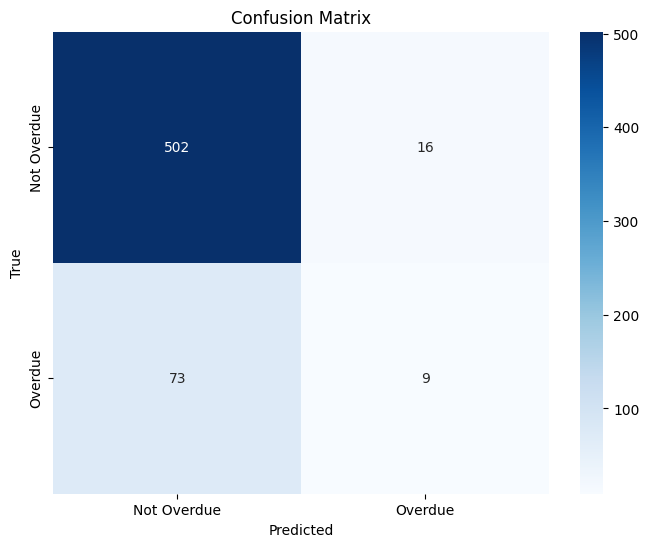

In [14]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Overdue", "Overdue"], yticklabels=["Not Overdue", "Overdue"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Comentario: Los colores aquí pueden ser engañosos. Es preciso prestar atención a la fila de abajo, que es la que muestra los casos de mora, y en partticular, al cuadrante izquierdo, que muestra los casos en que tuvieron mora pero se predijo que no la tendrían, ya que estos son cruciales para nuestro problema de negocio. 

In [15]:
model.save("model/lightgbm_deuda.pkl")